## Extract data from followed-by trigger language files
Files with trigger laguage are located in \\\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\HasTriggerLanguage

In [9]:
html = '<html><head><title>Hi</title></head><body>Hello, {World}!</body>'

file = open("hello.html","w")
file.write(html)
file.close()

from IPython.display import IFrame

IFrame(src='./hello.html', width=700, height=60)

In [19]:
global text

with open('hello.html') as f:    
    text = f.read()

text = text.replace('{World}', 'Guest')

with open('hello.html', 'w') as f:
    f.write(text)
    
IFrame(src='./hello.html', width=700, height=60)

In [7]:

from IPython.display import display, HTML
display(HTML('<div id="foobar" style="font-weight:bold">foobarbaz<br/><p>baz</p></div>'))

In [5]:
import glob
tl_files = glob.glob(r'\\legal.regn.net\DAY\Shares\Themis\GoldenFTraining\HasTriggerLanguage\*.xml')

### Use regex to find citation elements 
It is expensive to create DOM for the entire document as some documents may not have trigger language. The approach is to break the document into top level paragraph text fragments and then locate cites and trigger language in each fragment. If trigger language is located, DOM is created for the paragraph fragment.

In [1]:
import re

trigger = re.compile(r'(<laaa:treatmentTrigger.*</laaa:treatmentTrigger>)')

def find_trigger(s):  
    '''Find trigger elements in given text fragment'''
    return trigger.findall(s)

paragph = re.compile(r'(<lnvxe:text>.*?</lnvxe:text>)')

def find_paragph(s): 
    '''Find top level paragraph elements in given text fragment'''
    return paragph.findall(s)

### Parse document using lxml etree

In [30]:
from lxml import etree as ElementTree


def xml_to_tree(fragment):
    '''Return ElementTree for given xml text'''
    namespaces = {'laaa':'http://www.w3.org/laaa', 'lnci':'http://www.w3.org/lnci', 'lnvxe':'http://www.w3.org/lnvxe' }
    ns = ' '.join(('xmlns:{}="{}"'.format(*i) for i in namespaces.items()))
    xml = '<doc {}>{}</doc>'.format(ns, fragment)
    tree = ElementTree.fromstring(xml)
    return tree, namespaces


def find_element_attributes(tag, attr, value, fragment):
    '''
    Return attribute list of the first element based on tag and attribute value.
    '''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath(".//{}[@{}='{}']".format(tag, attr, value), namespaces=namespaces)
    attributes = elements[0].attrib if elements else []
    return attributes


def find_descendants(tag, attr, value, tree, namespaces):
    '''
    Return descendant elements based on tag and attribute value.
    '''
    elements = tree.xpath(".//{}[@{}='{}']".format(tag, attr, value), namespaces=namespaces)
    return elements


def embedded_cite(id, fragment):
    '''Return True if given text contains a lnci:cite element with ID attribute = id'''
    attributes = find_element_attributes('lnci:cite', 'ID', id, fragment)
    return True if attributes else False


def find_cite_references(fragment):
    '''Return list of cite id referenced by treatment trigger in given xml text'''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.findall('.//laaa:treatmentTriggerCiteReference', namespaces=namespaces)
    references = [e.attrib['ID'] for e in elements]
    return references


def find_case_references(fragment):
    '''Return list of case reference id in given xml text'''
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.findall('.//lnci:caseref', namespaces=namespaces)
    references = [e.attrib['ID'] for e in elements]
    return references

def find_cites(fragment):
    '''Return list of cite id in given xml text'''
    def cite_followed(elements):
        letters = [e.attrib['letter'] for e in elements]
        return 'f' in letters
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//lnci:cite', namespaces=namespaces)
    fletr = [cite_followed(find_descendants('lnci:editletter', 'letter', 'f', e, namespaces)) for e in elements]
    cites = [e.attrib['ID'] for e in elements]
    return list(zip(cites, fletr))


def find_trigger_section(fragment):
    '''
    Return top level laaa:treatmentTrigger xml content as a string
    laaa:treatmentTrigger can have nested laaa:treatmentTrigger elements, return only top level elements.
    Nested laaa:treatmentTrigger has laaa:treatmentTriggerText as parent.
    ElementTree.tostring(...) returns trailing text after the end tag, so use regex to clean the xml string.
    '''
    if not find_trigger(fragment):
        return []
    tree, namespaces = xml_to_tree(fragment)
    elements = tree.xpath('.//laaa:treatmentTrigger', namespaces=namespaces)
    trigger_text_tag = '{http://www.w3.org/laaa}treatmentTriggerText'
    elements = [e for e in elements if e.xpath('..')[0].tag != trigger_text_tag]
    sections = [ElementTree.tostring(e, method='xml', encoding='utf-8').decode() for e in elements]
    sections = [find_trigger(s)[0] for s in sections]
    return sections


def find_trigger_language(fragment):
    '''
    Return all the text embedded within laaa:treatmentTriggerText elements in given laaa:treatmentTrigger xml string 
    '''
    namespaces = {'laaa':'http://www.w3.org/laaa', 'lnci':'http://www.w3.org/lnci', 'lnvxe':'http://www.w3.org/lnvxe' }
    parser = ElementTree.XMLParser(recover=True)
    root = ElementTree.fromstring(fragment, parser)
    elements = root.findall('.//', namespaces)
    trigger_elements = [e for e in elements if e.tag == '{http://www.w3.org/laaa}treatmentTriggerText']
    language = ''.join(trigger_elements[0].itertext())
    group_id = root.attrib['groupIdentifier']
    fragment_id = root.attrib['fragmentNumber']
    fragments = root.attrib['totalFragments']
    editor_id = root.attrib['editorId']
    return language, group_id, fragment_id, fragments

def get_text(fragment):
    '''Return all the text within given xml string'''
    tree, namespaces = xml_to_tree(fragment)
    return ''.join(tree.itertext())

In [41]:
import os

language_dict = {}

def dump_trigger_language(para, para_index):
    trgrs = find_trigger_section(para)
    for trgr in trgrs:
        language, group_id, fragment_id, cnt_fragment = find_trigger_language(trgr)
        cite_references = find_cite_references(trgr)
        group_list = language_dict.get(group_id, [])
        group_list.append((int(fragment_id), int(cnt_fragment), int(para_index), cite_references, language))
        language_dict[group_id] = group_list
    
for file in tl_files[:20]:
    f = open(file, "r", encoding="utf-8")
    content = f.read()
    try:
        print(os.path.basename(f.name), 'xml ok', sep=':')
        language_dict.clear()
        for index, para in enumerate(find_paragph(content)):
            cites = find_cites(para)
            followed_cites = filter(lambda x: x[1] == True, cites)
            for cite in followed_cites:
                print('cite:',cite[0])
            dump_trigger_language(para, index)
        print('trigger language groups:', '\n', language_dict, sep='')
    except Exception as e:
        print(os.path.basename(f.name), 'xml error', e, sep=':')
    f.close()

BL00116347.XML:xml ok
cite: I5VVTW7F2N1R6D0040000400
trigger language groups:
{'I1G45D165GR0007VN3400001': [(1, 2, 3, ['I5VVTW7F2N1R6D0040000400'], 'Plaintiffs have satisfied the requirements for the issuance of a preliminary injunction'), (2, 2, 4, ['I5VVTW7F2N1R6D0040000400'], 'To obtain a preliminary injunction, a party must demonstrate "(1) a substantial likelihood of success on the merits; (2) that irreparable injury will be suffered if the relief is not granted; (3) that the threatened injury outweighs the harm the relief would inflict on the nonmovant; and (4) that the entry of the relief would serve the public interest." Schiavo ex. rel Schindler v. Schiavo, 403 F.3d 1223, 1225-26 (11th Cir. 2005)')]}
BL00211658.XML:xml ok
trigger language groups:
{'I7V10SSDDPB000GFHY100001': [(1, 2, 67, ['I5VW15DW2N1R7H0JT0000400', 'I5VW15DW2N1R7H0JK0000400', 'I5VW15DW2N1R7H0JF0000400'], 'the United States Supreme Court has instructed that'), (2, 2, 67, ['I5VW15DW2N1R7H0JT0000400', 'I5VW15DW2N

BL01424111.XML:xml ok
cite: I5VY47BD2203380070000400
trigger language groups:
{'I52W09SS9J5000PJDWT00001': [(1, 2, 24, ['I5VY47BD2203380070000400'], "Thus, [the plaintiff] need not have defaulted on anything to trigger the statute and fee provision. Rather, it is [the plaintiff's] unsuccessful attempt to sue the [defendants] for default and collection which resulted in the [defendants] incurring attorney's fees. Florida law allows them to recoup these fees from [the plaintiff] under the terms of the parties' agreement."), (2, 2, 26, ['I5VY47BD2203380070000400'], "As in GEMB, here, we hold that the availability of attorney's fees was determined by the cause of action asserted in Appellees' complaint, not the disposition of the case.")]}
BL01428689.XML:xml ok
cite: I5VXB1672D6NB80060000400
cite: I5VXB1672D6NB800B0000400
cite: I5VXB1672D6NB803J0000400
cite: I5VY5C082202RK0010000400
trigger language groups:
{'I1N4X1KHMF200046KM800001': [(1, 1, 51, ['I5VXB1672D6NB803J0000400'], "We also con

In [4]:
def f_letter(text):
    return False if not text else text != 'f'

f_letter('ff')

True

<table style="float:left">
        <tr>
            <th style="text-align:left;">Name</td>
            <th style="text-align:left;">Description</td>
        </tr>
        <tr>
            <td style="text-align:left;">para_element</td>
            <td style="text-align:left;">xml with root element &lt;lnvxe:text&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">para_text</td>
            <td style="text-align:left;">paragraph text</td>
        </tr>
        <tr>
            <td style="text-align:left;">trgr_element</td>
            <td style="text-align:left;">xml with root element &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">trgr_language</td>
            <td style="text-align:left;">text contained in element &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_in_para</td>
            <td style="text-align:left;">number of &lt;lnci:cite&gt; elements within para_element</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_referenced</td>
            <td style="text-align:left;">number of &lt;laaa:treatmentTriggerCiteReference&gt; elements within &lt;laaa:treatmentTrigger&gt;</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_embedded</td>
            <td style="text-align:left;">number of &lt;laaa:treatmentTriggerCiteReference&gt; elements for which referenced &lt;lnci:cite&gt; is within trgr_element</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_external</td>
            <td style="text-align:left;">number of &lt;laaa:treatmentTriggerCiteReference&gt; elements for which referenced &lt;lnci:cite&gt; is outside trgr_element</td>
        </tr>
        <tr>
            <td style="text-align:left;">cnt_cite_referenced_in_para</td>
            <td style="text-align:left;">number of &lt;laaa:treatmentTriggerCiteReference&gt; elements for which referenced &lt;lnci:cite&gt; is within para_element containing trgr_element</td>
        </tr>
        <tr>
            <td style="text-align:left;">cite_reference</td>
            <td style="text-align:left;">cite reference dictionary key: Cite ID, value: [external|embedded]</td>
        </tr>

</table>




In [492]:
import os
import pandas as pd  


def get_cite_references(trgr):
    '''
    Return dictionary of cite references, count of embedded cites, count of external cites 
    in given trigger section.
    example dictionary of cite references:
    {'I5VW15DW2N1R7H0JT0000400':'external', 'I5W19G8R1T51580030000400':'embedded'}
    '''
    cite_references = find_cite_references(trgr)
    cite_reference_dict = {}
    cite_type_dict = {}
    for cite_id in cite_references:
        cite_type = 'embedded' if embedded_cite(cite_id, trgr) else 'external'
        cite_type_dict[cite_type] = cite_type_dict.get(cite_type, 0) + 1
        cite_reference_dict[cite_id] = cite_type
    embedded_count = cite_type_dict.get('embedded', 0)
    external_count = cite_type_dict.get('external', 0)
    return cite_reference_dict, embedded_count, external_count


trigger_language_dict_metadata = ['para_text', 
                                  'trgr_element', 
                                  'trgr_language', 
                                  'group_id', 
                                  'fragment_id', 
                                  'editor_id', 
                                  'cnt_cite_in_para', 
                                  'cite_reference', 
                                  'cnt_cite_referenced',  
                                  'cnt_cite_referenced_in_para',
                                  'cnt_cite_embedded', 
                                  'cnt_cite_external']

def make_trigger_language_dict(filename, para, para_id, **kwargs):
    '''Utility function to make a dictionary object for trigger language'''
    trigger_language_dict = {'filename': filename, 'para_element': para, 'para_id': para_id}
    for key, value in kwargs.items():
        if key not in trigger_language_dict_metadata:
            raise ValueError('unknown key {}'.format(key))
        trigger_language_dict[key] = value
    return trigger_language_dict


trigger_language_list = []


def process_trigger_sections(file, para, para_id, trgrs):
    '''
    Create dictionary for each section that has trigger language
    and append to list
    '''
    for trgr in trgrs:   
        language, group_id, fragment_id, editor_id = find_trigger_language(trgr)
        cite_reference_dict, embedded_count, external_count = get_cite_references(trgr)
        cites_referenced_in_trigger = list(cite_reference_dict.keys())
        cites_in_para = find_cites(para)
        cnt_cite_referenced_in_para = len(set(cites_in_para) & set(cites_referenced_in_trigger))
        cite_count = len(cites_in_para)
        para_text = get_text(para)
        trigger_language_dict = make_trigger_language_dict(file, para, para_id,
            para_text=para_text, 
            trgr_element=trgr, 
            trgr_language=language, 
            group_id=group_id, 
            fragment_id=fragment_id, 
            editor_id=editor_id,                                                           
            cite_reference=cite_reference_dict,
            cnt_cite_embedded=embedded_count,
            cnt_cite_external=external_count,
            cnt_cite_referenced=embedded_count+external_count,
            cnt_cite_referenced_in_para=cnt_cite_referenced_in_para,                                               
            cnt_cite_in_para=cite_count
        )
        trigger_language_list.append(trigger_language_dict)

        
def process_notrigger_para(file, para, para_id):
    '''
    Create dictionary when no no trigger language is present
    and append to list
    '''
    cite_count = len(find_cites(para))
    para_text = get_text(para)
    trigger_language_dict = make_trigger_language_dict(file, para, para_id,
        para_text=para_text,                                               
        trgr_element='', 
        trgr_language='', 
        group_id='', 
        fragment_id='', 
        editor_id='',             
        cite_reference={},
        cnt_cite_embedded=0,
        cnt_cite_external=0,
        cnt_cite_referenced=0,
        cnt_cite_referenced_in_para=0,
        cnt_cite_in_para=cite_count                                                                                                   
    )
    trigger_language_list.append(trigger_language_dict)
    
    
def extract_trigger_language(file, content):
    '''Find trigger language in given content and process it'''
    for index, para in enumerate(find_paragph(content)):
        trgrs = find_trigger_section(para)
        if trgrs:
            process_trigger_sections(file, para, index, trgrs)
        else:
            process_notrigger_para(file, para, index)

for file in files:
    f = open(file, "r", encoding="utf-8")
    content = f.read()
    try:
        extract_trigger_language(os.path.basename(f.name), content)
        print(os.path.basename(f.name), 'xml ok', sep=':')
    except Exception as e:
        print(os.path.basename(f.name), 'xml error', e, sep=':')
    f.close()

BL00211658.XML:xml ok
BL00267826.XML:xml ok
BL00915946.XML:xml ok
BL01258106.XML:xml ok
BL01258142.XML:xml ok
BL01258203.XML:xml ok
BL01262550.XML:xml ok
BL01310123.XML:xml ok
BL01386915.XML:xml ok
BL01408914.XML:xml ok
BL01415548.XML:xml ok
BL01424111.XML:xml ok
BL01428689.XML:xml ok
BL01430546.XML:xml ok
BL01430577.XML:xml ok
BL01430637.XML:xml ok
BL01442880.XML:xml ok
BL01480982.XML:xml ok
BL01496348.XML:xml ok
BL01505881.XML:xml ok
BL01516274.XML:xml ok
BL01516294.XML:xml ok
BL01517770.XML:xml ok
BL01521475.XML:xml ok
BL01565589.XML:xml ok
BL01601333.XML:xml ok
BL01606670.XML:xml ok
BL01612883.XML:xml ok
BL01616462.XML:xml ok
BL01623459.XML:xml ok
BL01637917.XML:xml ok
BL01649135.XML:xml ok
BL01649136.XML:xml ok
BL01652458.XML:xml ok
BL01652508.XML:xml ok
BL01664387.XML:xml ok
BL01666283.XML:xml ok
BL01667541.XML:xml ok
BL01668506.XML:xml ok
BL01670195.XML:xml ok
BL01670210.XML:xml ok
BL01671094.XML:xml ok
BL01672651.XML:xml ok
BL01678966.XML:xml ok
BL01689048.XML:xml ok
BL01709459

BL03589665.XML:xml ok
BL03589666.XML:xml ok
BL03589891.XML:xml ok
BL03595685.XML:xml ok
BL03597851.XML:xml ok
BL03597902.XML:xml ok
BL03598250.XML:xml ok
BL03598896.XML:xml ok
BL03603066.XML:xml ok
BL03608769.XML:xml ok
BL03622322.XML:xml ok
BL03632269.XML:xml ok
BL03634057.XML:xml ok
BL03637185.XML:xml ok
BL03638350.XML:xml ok
BL03643642.XML:xml ok
BL03644502.XML:xml ok
BL03645022.XML:xml ok
BL03645115.XML:xml ok
BL03645290.XML:xml ok
BL03645375.XML:xml ok
BL03645795.XML:xml ok
BL03645821.XML:xml ok
BL03648792.XML:xml ok
BL03648801.XML:xml ok
BL03652542.XML:xml ok
BL03652555.XML:xml ok
BL03652557.XML:xml ok
BL03652566.XML:xml ok
BL03652601.XML:xml ok
BL03652635.XML:xml ok
BL03652638.XML:xml ok
BL03653589.XML:xml ok
BL03653597.XML:xml ok
BL03653603.XML:xml ok
BL03729760.XML:xml ok
BL03736963.XML:xml ok
BL03799679.XML:xml ok
BL03826135.XML:xml ok
BL03831841.XML:xml ok
BL03831858.XML:xml ok
BL03838206.XML:xml ok
BL03860234.XML:xml ok
BL03863621.XML:xml ok
BL03871618.XML:xml ok
BL03874473

### Analyze trigger language using a DataFrame

In [493]:
trigger_language_rows = []

def convert_trigger_language():
    for item in trigger_language_list:        
        row = [item['filename'], 
               item['para_id'], 
               item['para_element'], 
               item['para_text'], 
               item['cnt_cite_in_para'], 
               item['trgr_element'],                
               item['trgr_language'], 
               item['group_id'], 
               item['fragment_id'], 
               item['editor_id'],                
               item['cnt_cite_referenced'], 
               item['cnt_cite_embedded'], 
               item['cnt_cite_external'], 
               item['cnt_cite_referenced_in_para'], 
               item['cite_reference']]
        trigger_language_rows.append(row)

convert_trigger_language()

columns = ['filename', 
           'para_id', 
           'para_element', 
           'para_text', 
           'cnt_cite_in_para', 
           'trgr_element', 
           'trgr_language', 
           'group_id', 
           'fragment_id', 
           'editor_id', 
           'cnt_cite_referenced',
           'cnt_cite_embedded', 
           'cnt_cite_external', 
           'cnt_cite_referenced_in_para',
           'cite_reference']

df = pd.DataFrame(trigger_language_rows, columns = columns, dtype = int) 
df 

filename  para_id  \
0                                       BL00211658.XML        0   
1                                       BL00211658.XML        1   
2                                       BL00211658.XML        2   
3                                       BL00211658.XML        3   
4                                       BL00211658.XML        4   
5                                       BL00211658.XML        5   
6                                       BL00211658.XML        6   
7                                       BL00211658.XML        7   
8                                       BL00211658.XML        8   
9                                       BL00211658.XML        9   
10                                      BL00211658.XML       10   
11                                      BL00211658.XML       11   
12                                      BL00211658.XML       12   
13                                      BL00211658.XML       13   
14                                      BL00211658.XML       14   
15                                      BL00211658.XML       15   
16                                      BL00211658.XML       16   
17                                      BL00211658.XML       17   
18                                      BL00211658.XML       18   
19                                      BL00211658.XML       19   
20                                      BL00211658.XML       20   
21                                      BL00211658.XML       21   
22                                      BL00211658.XML       22   
23                                      BL00211658.XML       23   
24                                      BL00211658.XML       24   
25                                      BL00211658.XML       25   
26                                      BL00211658.XML       26   
27                                      BL00211658.XML       27   
28                                      BL00211658.XML       28   
29                                      BL00211658.XML       29   
...                                                ...      ...   
39290  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       27   
39291  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       28   
39292  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       29   
39293  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       30   
39294  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       30   
39295  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       31   
39296  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       32   
39297  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       33   
39298  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       34   
39299  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       35   
39300  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       36   
39301  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       37   
39302  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       38   
39303  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       39   
39304  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       40   
39305  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       41   
39306  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       42   
39307  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       43   
39308  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       44   
39309  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       45   
39310  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       46   
39311  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       47   
39312  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       48   
39313  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       49   
39314  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       50   
39315  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       51   
39316  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       52   
39317  BR23355_5W17-FC01-FC6N-X001-00000-00_MERGED.XML       53   
39318  BR23355_5W17-FC01-F

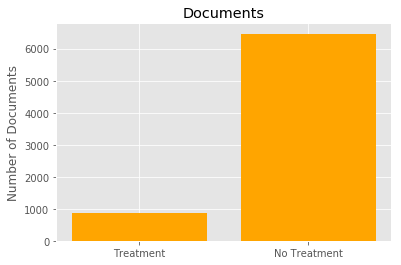

In [504]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['Treatment', 'No Treatment']
documents = [len(tl_files), len(nt_files)]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, documents, color='orange')
plt.ylabel("Number of Documents")
plt.title("Documents")

plt.xticks(x_pos, x)

plt.show()

Text(0.5, 1.0, 'Distribution of Paragraphs with Trigger Language ')

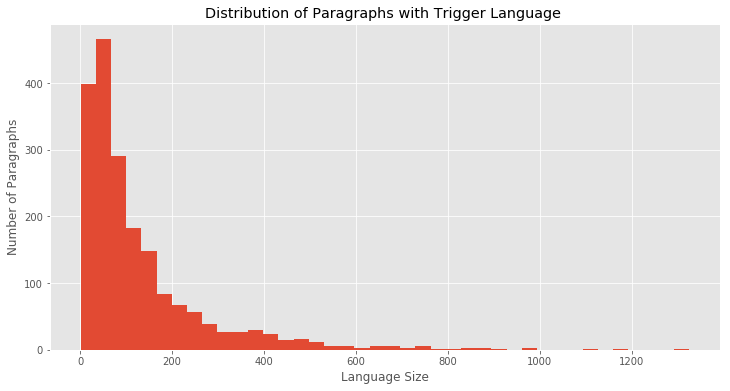

In [505]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
hist = trgr_data.hist(column="language_size", bins=40, figsize=(12,6))
hist[0][0].set_ylabel('Number of Paragraphs')
hist[0][0].set_xlabel('Language Size')
hist[0][0].set_title('Distribution of Paragraphs with Trigger Language ')

Text(0.5, 1.0, 'Distribution of Trigger Language Paragraph Groups ')

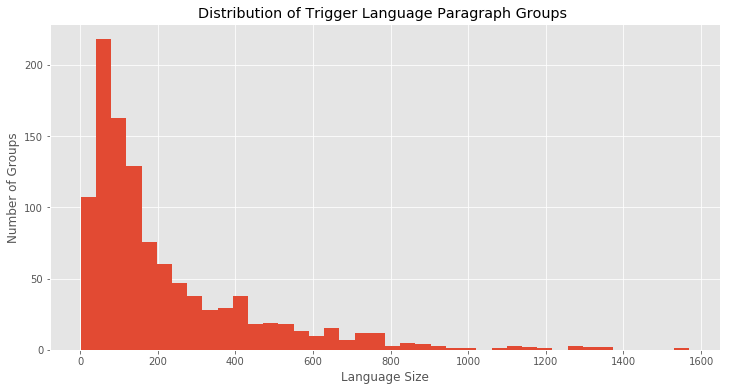

In [507]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
size_data = lang_data.groupby(['group_id'])['language_size'].agg('sum').to_frame('language_size')
hist = size_data.hist(column="language_size", bins=40, figsize=(12,6))
hist[0][0].set_ylabel('Number of Groups')
hist[0][0].set_xlabel('Language Size')
hist[0][0].set_title('Distribution of Trigger Language Paragraph Groups ')

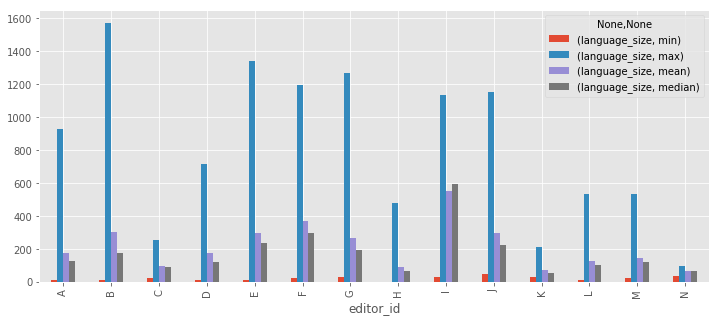

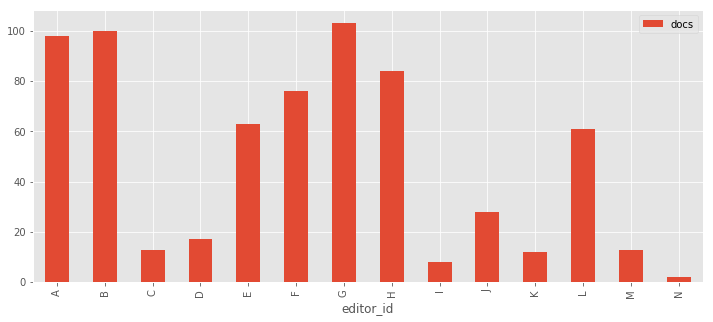

In [517]:
trgr_data = pd.DataFrame(df.query('trgr_language != ""'))
trgr_data["language_size"] = trgr_data["trgr_language"].str.len()
lang_data = trgr_data[['editor_id','language_size', 'group_id']]
size_data = lang_data.groupby(['group_id'])['language_size'].agg('sum').to_frame('language_size')
editor_data = lang_data.groupby(['group_id'])['editor_id'].agg('max').to_frame('editor_id')
editor_data['language_size'] = size_data['language_size']
editor_data = editor_data.reset_index().drop(columns=['group_id']).groupby(['editor_id']).agg(['min','max', 'mean', 'median'])
editor_data.plot.bar(figsize=(12,5))
doc_data = trgr_data.groupby(['filename'])['editor_id'].agg('max').to_frame().groupby(['editor_id']).size().to_frame('docs')
doc_data.plot.bar(figsize=(12,5))

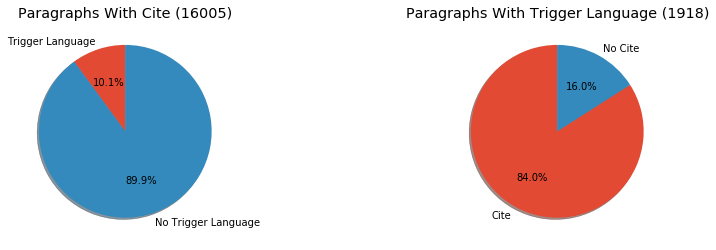

In [511]:
import matplotlib.pyplot as plt

cnt_para_with_trgr_lang = df.query('trgr_language != ""')['para_id'].count()
cnt_para_with_cite_and_no_trgr_lang = df.query('cnt_cite_in_para > 0 and trgr_language == ""')['para_id'].count()
cnt_para_with_no_cite_and_trigger_lang = df.query('cnt_cite_in_para == 0 and trgr_language != ""')['para_id'].count()
cnt_para_with_cite_and_trigger_lang = df.query('cnt_cite_in_para > 0 and trgr_language != ""')['para_id'].count()

fig = plt.figure(figsize=(12, 6))

labels = 'Trigger Language', 'No Trigger Language'
sizes = [cnt_para_with_cite_and_trigger_lang, cnt_para_with_cite_and_no_trgr_lang]
ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.set_title('Paragraphs With Cite ({})'.format(sum(sizes)))

labels = 'Cite', 'No Cite'
sizes = [cnt_para_with_cite_and_trigger_lang, cnt_para_with_no_cite_and_trigger_lang]
ax2 = fig.add_axes([.5, 0, .5, .5], aspect=1)
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.set_title('Paragraphs With Trigger Language ({})'.format(sum(sizes)))

plt.show()

In [513]:
df.query('cnt_cite_in_para == 0 and trgr_language != ""')

filename  para_id  \
649    BL01408914.XML      146   
968    BL01430577.XML       25   
971    BL01430577.XML       28   
1001   BL01430637.XML       17   
1147   BL01442880.XML      142   
1226   BL01480982.XML       29   
1242   BL01480982.XML       45   
1457   BL01505881.XML      153   
1460   BL01505881.XML      156   
1550   BL01516294.XML       35   
1551   BL01516294.XML       35   
2328   BL01666283.XML        4   
2329   BL01666283.XML        4   
2446   BL01670195.XML       26   
2745   BL01671094.XML       77   
2982   BL01689048.XML        5   
3069   BL01734612.XML       51   
3151   BL01756830.XML       35   
3299   BL01785780.XML       56   
3710   BL02008383.XML       18   
3711   BL02008383.XML       18   
3783   BL02017160.XML       28   
3784   BL02017160.XML       28   
3802   BL02027903.XML       11   
3831   BL02053790.XML        4   
4200   BL02077297.XML       58   
4422   BL02149393.XML       94   
4544   BL02157240.XML       91   
4549   BL02157240.XML       96   
4658   BL02163257.XML       23   
...               ...      ...   
37127  BL88456220.XML       44   
37160  BL90442462.XML       21   
37171  BL90442462.XML       32   
37210  BL90443861.XML        9   
37211  BL90443861.XML        9   
37320  BL90448767.XML       12   
37321  BL90448767.XML       12   
37322  BL90448767.XML       12   
37442  BL91609730.XML       37   
37475  BL91699410.XML       25   
37476  BL91699410.XML       25   
38018  BL94992450.XML       41   
38020  BL94992450.XML       43   
38035  BL94992450.XML       58   
38114  BL95152221.XML       26   
38606  BL97635579.XML        8   
38913  BL98378336.XML      298   
38914  BL98378336.XML      298   
38915  BL98378336.XML      298   
38944  BL98378336.XML      327   
38946  BL98378336.XML      329   
38947  BL98378336.XML      329   
38948  BL98378336.XML      329   
38955  BL98378336.XML      336   
38985  BL98378336.XML      366   
38991  BL98378336.XML      372   
38998  BL98378336.XML      379   
39001  BL98378336.XML      382   
39004  BL98378336.XML      385   
39105  BL98665476.XML       35   

                                            para_element  \
649    <lnvxe:text><page count="44" resourcekey="urn:...   
968    <lnvxe:text><laaa:treatmentTrigger createdDate...   
971    <lnvxe:text><laaa:treatmentTrigger createdDate...   
1001   <lnvxe:text><laaa:treatmentTrigger createdDate...   
1147   <lnvxe:text>We have tried to pull the interpre...   
1226   <lnvxe:text><laaa:treatmentTrigger createdDate...   
1242   <lnvxe:text>For the above reasons, we hold tha...   
1457   <lnvxe:text>Here, Ms. Perez has the requisite ...   
1460   <lnvxe:text>The three legal organizations repr...   
1550   <lnvxe:text>P24 <laaa:treatmentTrigger created...   
1551   <lnvxe:text>P24 <laaa:treatmentTrigger created...   
2328   <lnvxe:text>While t<laaa:treatmentTrigger crea...   
2329   <lnvxe:text>While t<laaa:treatmentTrigger crea...   
2446   <lnvxe:text><laaa:treatmentTrigger createdDate...   
2745   <lnvxe:text><laaa:treatmentTrigger createdDate...   
2982   <lnvxe:text><laaa:treatmentTrigger createdDate...   
3069   <lnvxe:text><page count="P32" resourcekey="urn...   
3151   <lnvxe:text>Second, in support of their argume...   
3299   <lnvxe:text><page count="P34" medianeutralrsc=...   
3710   <lnvxe:text><page count="P11" resourcekey="urn...   
3711   <lnvxe:text><page count="P11" resourcekey="urn...   
3783   <lnvxe:text><laaa:treatmentTrigger createdDate...   
3784   <lnvxe:text><laaa:treatmentTrigger createdDate...   
3802   <lnvxe:text>Instead, Olli attempts to rebut fa...   
3831   <lnvxe:text><laaa:treatmentTrigger createdDate...   
4200   <lnvxe:text><laaa:treatmentTrigger createdDate...   
4422   <lnvxe:text><laaa:treatmentTrigger createdDate...   
4544   <lnvxe:text><laaa:treatmentTrigger createdDate...   
4549   <lnvxe:text>Defendants <laaa:treatmentTrigger ...   
4658   <lnvxe:text><laaa:treatmentTrigger createdDate...   
...                                         